In [3]:
# utilities
import re
import numpy as np
import pandas as pd
import joblib
import os

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
# utility function to export graphs
def save_fig(fig_name, tight_layout=True, fig_extension="png", resolution=300, images_path = './images'):
    if not os.path.exists(images_path):
        os.makedirs(images_path)
    path = os.path.join(images_path, fig_name + "." + fig_extension)
    print("Saving figure", fig_name)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [27]:
# Import the dataset
DATASET_COLUMNS = ['sentiment', 'ids', 'date', 'flag', 'user', 'text']
DATASET_ENCODING = 'ISO-8859-1'
dataset = pd.read_csv('./data/training.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)

In [28]:
dataset.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Saving figure Distribution


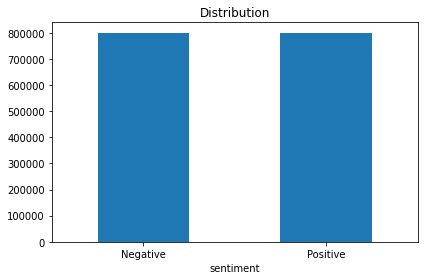

In [29]:
# removing the unnecessary columns
dataset = dataset[['sentiment', 'text']]
dataset['sentiment'] = dataset['sentiment'].replace(4, 1)

# plotting the distribution for dataset
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution', legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
save_fig("Distribution")

In [31]:
dataset.to_csv("training.csv", index=False)

In [7]:
# storing data in lists
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

Preprocessing steps:
1. Lower casing
2. Replacing URLs: links starting with "HTTP", "HTTPS", "WWW" are replaced by "URL"
3. Replacing Emojis: mapped against the pre-defined dict
4. Replacing Usernames: replace @USERNAME with "USER"
5. Removing Non-alphabets: replace characters except digits and alphabets with a space
6. Removing Consecutive letters: e.g. heyyyy to heyy
7. Removing short words: words with length less than 2 are removed
8. removing stop words
9. Lemmatizing

In [8]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}
# stopwords
import nltk
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

# English vocabulary
WORDS = set(nltk.corpus.words.words())

In [ ]:
def preprocess_tweet(textdata: str) -> List[str]:
    """
    Apply filters and transformations on each text record
    :param textdata: str
    :return: List[str]
    """
    processedText = []


    # Defining regex patterns.
    urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern = '@[^\s]+'
    alphaPattern = "[^a-zA-Z0-9]"
    sequencePattern = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"

    tweet = textdata.lower()

    # Replace all URls with 'URL'
    tweet = re.sub(urlPattern, ' ', tweet)
    # Replace all emojis.
    for emoji in EMOJIS.keys():
        tweet = tweet.replace(emoji, "EMOJI" + EMOJIS[emoji])
        # Replace @USERNAME to 'USER'.
    tweet = re.sub(userPattern, ' ', tweet)
    # Replace all non alphabets.
    tweet = re.sub(alphaPattern, " ", tweet)
    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
    # Replace non-english words
    tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet) if w.lower() in WORDS)

    tweetwords = ''
    for word in tweet.split():
        # Checking if the word is a stopword.
        if word not in STOPWORDS:
            # Replace non-english words
            if len(word) > 1:
                tweetwords += (word + ' ')
    processedText.append(tweetwords)
    return processedText


In [9]:
def preprocess(textdata):
    processedText = []
    for tweet in textdata:
        tweetwords = preprocess_tweet(tweet)
        processedText.append(tweetwords)      
    return processedText

In [10]:
# resolve nltk depencies in wordnetlemmatizer
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /Users/joswx/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/joswx/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [11]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 102 seconds


In [12]:
# splitting the data
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment, test_size=0.05, random_state=42)
print(f'Data Split Done')

Data Split Done


In [25]:
dataset.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [13]:
# TF-IDF vectoriser
vectoriser = TfidfVectorizer(max_features=50000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.
No. of feature_words:  50000


/Users/joswx/Documents/SWE5003/BEAD/sample/bead/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [14]:
# Transform the dataset
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


In [17]:
from sklearn.model_selection import cross_val_score
def cv_comparison(models, X, y, cv):
    cv_accuracies = pd.DataFrame()
    accs = []
    for model in models:
        acc = np.round(cross_val_score(model, X, y, scoring='accuracy', cv = cv), 4)
        accs.append(acc)
        acc_avg = round(acc.mean(), 4)
        cv_accuracies[str(model)] = [acc_avg]
    cv_accuracies.index = ['Accuracy']
    return cv_accuracies, accs

In [16]:
# models
BNBmodel = BernoulliNB(alpha=2)
SVCmodel = LinearSVC()
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)

In [18]:
models = [BNBmodel, SVCmodel, LRmodel]
comp, accs = cv_comparison(models, X_train, y_train, 10)

In [19]:
comp

,BernoulliNB(alpha=2),LinearSVC(),"LogisticRegression(C=2, max_iter=1000, n_jobs=-1)"
Accuracy,0.7781,0.7953,0.7994


In [20]:
accs

[array([0.779 , 0.778 , 0.7789, 0.7796, 0.7783, 0.7757, 0.7759, 0.7785,
        0.7798, 0.7778]),
 array([0.7958, 0.7953, 0.7958, 0.7958, 0.7955, 0.7953, 0.7931, 0.7955,
        0.7964, 0.7948]),
 array([0.7991, 0.7995, 0.8   , 0.7999, 0.7991, 0.7991, 0.7976, 0.8   ,
        0.8   , 0.7994])]

In [21]:
# hyperparameter tuning for log regression model
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
grid = dict(solver = solvers, penalty = penalty, C = c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.800025 using {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.792738 (0.001012) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.797562 (0.001000) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.792742 (0.001019) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.796158 (0.001100) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.797995 (0.001043) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.796161 (0.001099) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.800025 (0.001129) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.799759 (0.001058) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.800024 (0.001125) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.795923 (0.001029) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.795918 (0.001029) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.795926 (0.001028) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.779456 (0.001032) wit

In [ ]:
# Saving the model
file = open('./model/vectoriser-ngram-(1,1).pkl','wb')
joblib.dump(vectoriser, file)
file.close()

file = open('./model/Sentiment-svc.pkl', 'wb')
joblib.dump(SVCmodel, file)
file.close()

file = open('./model/Sentiment-LR.pkl','wb')
joblib.dump(LRmodel, file)
file.close()

file = open('./model/Sentiment-BNB.pkl','wb')
joblib.dump(BNBmodel, file)
file.close()

In [ ]:
# sample use case
def load_models():
    
    # Load the vectoriser.
    file = open('./model/vectoriser-ngram-(1,2).pkl', 'rb')
    vectoriser = joblib.load(file)
    file.close()
    # Load the LR Model.
    file = open('./model/Sentiment-LRv1.pkl', 'rb')
    LRmodel = joblib.load(file)
    file.close()
    
    return vectoriser, LRmodel

def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

if __name__=="__main__":
    # Loading the models.
    #vectoriser, LRmodel = load_models()
    
    # Text to classify should be in a list.
    text = ["BTC to the moon"]
    
    df = predict(vectoriser, LRmodel, text)
    print(df.head())